[[[ 1.  1.  1. ...  1.  1.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [ 1.  1.  1. ...  1.  1.  1.]
  [-0. -0. -0. ... -0. -0. -0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 1.  1.  1. ...  1.  1.  1.]]]
[[[ 0.98106026  0.98480775  0.96984631 ...  0.98480775  0.99240388
    0.98480775]
  [ 0.17364818 -0.17364818 -0.17364818 ... -0.17364818  0.08715574
   -0.        ]
  [-0.08583165 -0.          0.17101007 ... -0.         -0.08682409
    0.17364818]]

 [[-0.17298739  0.17364818  0.17101007 ...  0.17364818 -0.08682409
    0.        ]
  [ 0.98480775  0.98480775  0.98480775 ...  0.98480775  0.9961947
    1.        ]
  [ 0.01513444 -0.          0.03015369 ... -0.          0.00759612
    0.        ]]

 [[ 0.08715574  0.         -0.17364818 ...  0.          0.08715574
   -0.17364818]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.9961947   1.          0.98480775 ...  1. 

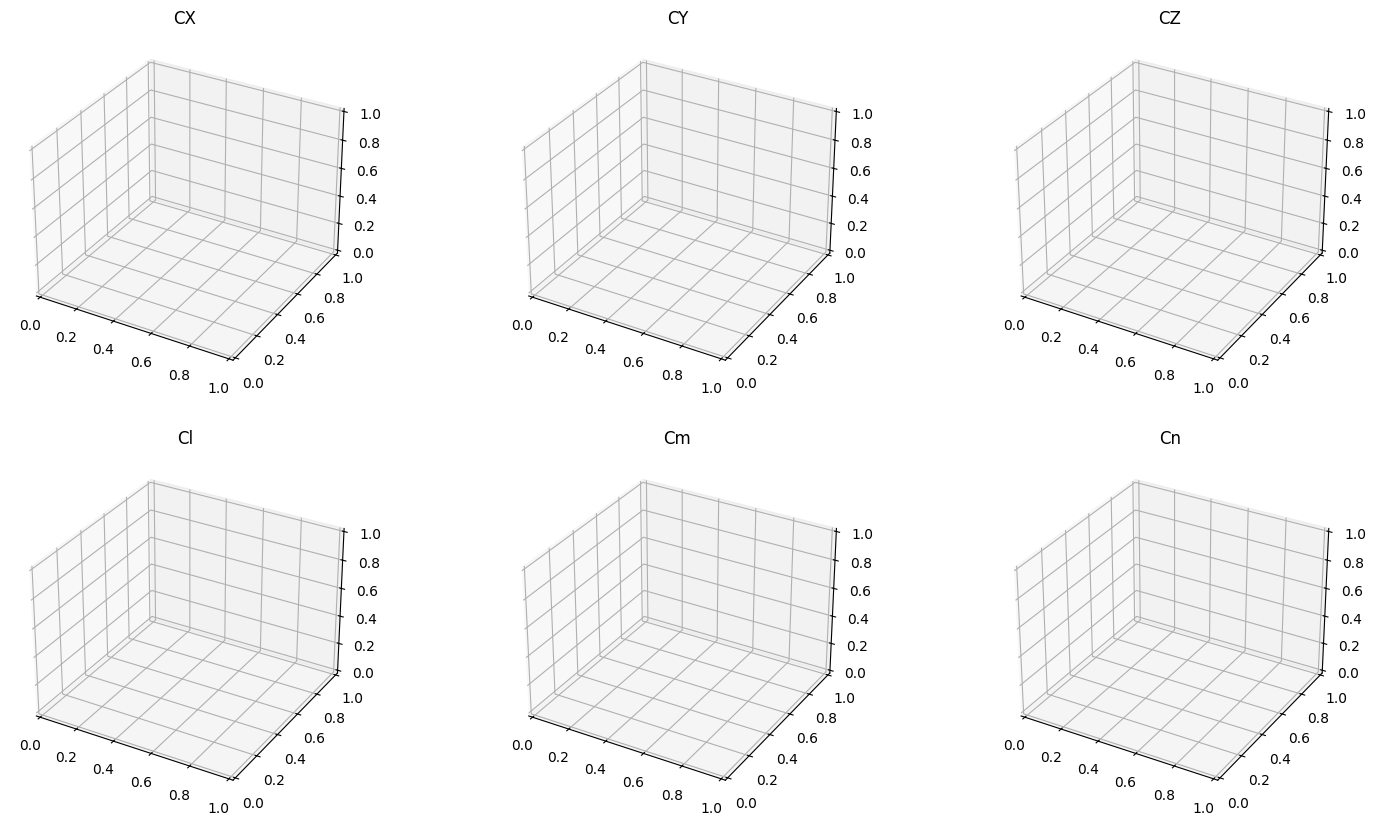

interactive(children=(FloatSlider(value=0.0, description='Aileron:', max=5.0, min=-5.0), FloatSlider(value=0.0…

In [15]:
"""
Preprocesses windtunnel and freestreem simulation data:
    - Loads simulation data from npz
    - Converts angles to radians
    - Flips signs of x and z axes to get from drag, lift to fx, fz (NED)
    - Flips sign of alpha to account convention differences.
    - Converts freestream simulation forces into the body frame
    - Centres control surface deflections around 0 (range -5, 5)
    - Converts from aerodynamic forces to coefficients
    - Scales velocities to account for size (Change in Reynolds)
    - Augments data by exploiting symmetries in xz-plane


NOTE:
The resulting data are inconsistent in the sideforce CY and yawing moment Cn.
A correction has been applied to account for this in accordance with my 
understanding of the definition of beta, however this is not a principled
solution to the problem.

The windtunnel data is in the wind frame whereas the freestream data is in the 
body frame.

TODO: Double-check results


CONVENTION FOR END RESULT:
    pos,    vel,    force,  omega,  moment
N   x       u       X       p       l
E   y       v       Y       q       m
D   z       w       Z       r       n

sign of moment and angular velocity -> positive right handed rotation, 
negative left handed.

alpha = atan(w / u)
beta = asin(v / |(u, v, w)^T|)

CONVENTION IN USE FOR REAL WINDTUNNEL DATA:

Signs give relation to the end result.

    pos,    vel,    force,  omega,  moment
S   -x      -u      -X      -p       -l
E   y       v       Y       -q       -m
U   -z      -w      -Z      -r       -n

alpha_r = atan(-w / u) = -alpha
beta = asin(-v / |(u, v, w)^T|) = -beta

NOTE: The results only seem to make sense when the moments are flipped

CONVENTION IN USE FOR SIMULATED WINDTUNNEL DATA:

Signs give relation to the end result.

    pos,    vel,    force,  omega,  moment
S   -x      -u      -X      -p       -l
E   -y      -v      -Y       q        m
U   -z      -w      -Z      -r       -n

alpha_r = atan(-w / u) = -alpha
beta = asin(-v / |(u, v, w)^T|) = -beta


CONVENTION IN USE FOR SIMULATED FREESTREAM DATA:

Signs give relation to the end result.

    pos,    vel,    force,  omega,  moment
S   -x      -u      -X      -p       -l
E   -y      -v      -Y       q        m
U   -z      -w      -Z      -r       -n

alpha_r = atan(-w / u) = -alpha
beta = asin(-v / |(u, v, w)^T|) = -beta


"""
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json

# Constants
RHO = 1.225 # air density
IN_TO_M = 0.0254
LBF_TO_N = 4.44822
LBS_TO_KG = 0.453592
MACH_TO_MS = 343


def R(alpha, beta):
    """
    Rotation matrix from wind to body axes. It is transposed for np.einsum

    Parameters
    ----------
    alpha : float
        Angle of attack in radians
    beta : float
        Sideslip angle in radians

    Returns
    -------
    R : numpy array
        Rotation matrix
    """
    R = np.zeros((3, 3, len(alpha)))
    R[0, 0] = np.cos(alpha) * np.cos(beta)
    R[0, 1] = - np.sin(beta) * np.cos(alpha)
    R[0, 2] = - np.sin(alpha)
    R[1, 0] = np.sin(beta)
    R[1, 1] = np.cos(beta)
    R[1, 2] = 0.
    R[2, 0] = np.cos(beta) * np.sin(alpha)
    R[2, 1] = - np.sin(beta) * np.sin(alpha)
    R[2, 2] = np.cos(alpha)
    return np.transpose(R, (1, 0, 2))

def process_sim_dataset(
        input:np.lib.npyio.NpzFile, 
        params:dict, 
        goal_params:dict, 
        degrees:bool = True,
        body:bool = False,
        augment:bool = True,
        axes:np.ndarray = np.ones((6, 1))
        ):
    """
    Takes as input a simulation dataset containing aerodynamic forces 
    and moments at given:
        - angles of attack
        - angles of sideslip
        - velocity
        - control surface deflection

    The forces and moments are assumed to be in a wind aligned (USE) frame.
    Moments are taken around 25% MAC.

    Parameters:
        - params: dictionary containing information about the aircraft for the 
                    data (span, chord, reference area, etc.)
        - goal_params: dictionary containing information about the aircraft 
                    to be simulated
        - degrees : flag to convert aerodynamic angles to radians
        - body : flag stating whether forces are already in the body frame
        - augment : flag for exploiting mirror symmetry in xz-plane
        - axes : custom flip for certain axes to account for inconsitencies in
                    the data

    Returns an array of aerodynamic coefficients defined in the NED coordinate 
    system. Moments are defined positive in the right handed sense.

    Conventions for the output:
        - alpha = atan(w / u) is positive for the nose facing towards the 
                                ground (down)
        - beta = asin(v / V) is positive for sideslip towards the right 
                            (as viewed from the perspective of a pilot)
        - delta_aileron is defined positive if the right wing 
                            (positive y direction) is deflected downward 
                            (positive z direction)
        - delta_elevator is defined positive if the elevator is deflected 
                            downward (positive z direction)
    """
    
    output = pd.DataFrame(columns = ['q', 'alpha', 'beta', 'aileron', 
                                     'elevator', 'windtunnel', 'CX', 'CY', 'CZ', 
                                     'Cl', 'Cm', 'Cn'])

    S = params['reference_area']
    b = params['span']
    c = params['chord']

    scale_factor = b / goal_params['span']
    
    q = np.array(input['vel'], dtype=float) ** 2 * 0.5 * RHO

    # sign flip for alpha convention in sim data vs control
    alpha = np.array(input['alpha'], dtype=float) 
    beta = np.array(input['beta'], dtype=float)

    if degrees:
        alpha = np.deg2rad(alpha)
        beta = np.deg2rad(beta)

    if body:
        rotmat = R(np.zeros_like(alpha), np.zeros_like(beta))
    else:
        # rotmat = R(alpha, beta)
        rotmat = R(-alpha, -beta)

    forces = np.array([
            np.array(input['fx'], dtype=float),
            np.array(input['fy'], dtype=float),
            np.array(input['fz'], dtype=float)
        ])
    forces *= axes[:3]

    moments = np.array([
            np.array(input['mx'], dtype=float),
            np.array(input['my'], dtype=float), 
            np.array(input['mz'], dtype=float)
            ])
    
    moments *= axes[3:]

    print(rotmat)

    forces = np.einsum('ijk,jk->ik', rotmat, forces).T
    moments = np.einsum('ijk,jk->ik', rotmat, moments).T

    output['CX'] = forces[:, 0] / (q * S)
    # output['CX'] = - forces[:, 0] / (q * S)
    output['CY'] = forces[:, 1] / (q * S)
    output['CZ'] = - forces[:, 2] / (q * S)

    output['Cl'] = - moments[:, 0] / (q * S * b)
    output['Cm'] = moments[:, 1] / (q * S * c)
    output['Cn'] = - moments[:, 2] / (q * S * b)

    # centre control surface deflections
    output['aileron'] = -(np.array(input['ctrl1'], dtype=float) - 5.0)
    output['elevator'] = -(np.array(input['ctrl2'], dtype=float) - 5.0)

    output['beta'] = - beta
    output['alpha'] = - alpha
    output['windtunnel'] = not body

    output['q'] = q * scale_factor ** 2

    if augment:
        mirrored = output.copy()

        mirrored['beta'] = - mirrored['beta']
        mirrored["CY"] = - mirrored["CY"]
        mirrored["Cl"] = - mirrored["Cl"]
        mirrored["Cn"] = - mirrored["Cn"]
        mirrored['aileron'] = - mirrored['aileron']

        output = pd.concat([output, mirrored], ignore_index=True)

    return output


def process_wt_dataset(
        input:pd.DataFrame, 
        params:dict, 
        goal_params:dict, 
        degrees:bool = True,
        body:bool = False,
        augment:bool = False,
        axes:np.ndarray = np.ones((6, 1))
        ):
    """
    Takes as input a windtunnel dataset containing aerodynamic coefficients 
    at given:
        - angles of attack
        - angles of sideslip
        - velocities

    The forces and moments are assumed to be in a wind aligned (USE) frame.
    Moments are taken around 25% of MAC.

    Parameters:
        - params: dictionary containing information about the aircraft for the 
                    data (span, chord, reference area, etc.)
        - goal_params: dictionary containing information about the aircraft 
                    to be simulated
        - degrees : flag to convert aerodynamic angles to radians
        - body : flag stating whether forces are already in the body frame
        - augment : flag for exploiting mirror symmetry in xz-plane

    Returns an array of aerodynamic coefficients defined in the NED coordinate 
    system. Moments are defined positive in the right handed sense.

    Conventions for the output:
        - alpha = atan(w / u) is positive for the nose facing towards the 
                                ground (down)
        - beta = asin(v / V) is positive for sideslip towards the right 
                            (as viewed from the perspective of a pilot)
        - delta_aileron is defined positive if the right wing 
                            (positive y direction) is deflected downward 
                            (positive z direction)
        - delta_elevator is defined positive if the elevator is deflected 
                            downward (positive z direction)
    """
    
    output = pd.DataFrame(columns = ['q', 'alpha', 'beta', 'aileron', 
                                     'elevator', 'windtunnel', 'CX', 'CY', 'CZ', 
                                     'Cl', 'Cm', 'Cn'])

    S = params['reference_area']

    scale_factor = params['span'] / goal_params['span']

    q = 0.5 * RHO * S * (input['MACH'] * MACH_TO_MS) ** 2

    # sign flip for alpha convention in sim data vs control
    alpha = np.array(input['ALPHAC'], dtype=float) 
    beta = np.array(input['PSI'], dtype=float)

    if degrees:
        alpha = np.deg2rad(alpha)
        beta = np.deg2rad(beta)

    if body:
        rotmat = R(np.zeros_like(alpha), np.zeros_like(beta))
        beta = beta
    else:
        rotmat = R(alpha, beta)
        # rotmat = R(alpha, beta)

    forces = np.array([
            np.array(input['CDWA'], dtype=float),
            np.array(input['CYWA'], dtype=float),
            np.array(input['CLWA'], dtype=float)
        ])
    forces *= axes[:3]
    
    moments = np.array([
            np.array(input['CRWA25'], dtype=float), # rolling coeff
            np.array(input['CMWA25'], dtype=float), # pitching coeff
            np.array(input['CNWA25'], dtype=float)  # yawing coeff
            ])

    moments *= axes[3:]
    print(rotmat)

    forces = np.einsum('ijk,jk->ik', rotmat, forces).T
    moments = np.einsum('ijk,jk->ik', rotmat, moments).T

    output['CX'] = -forces[:, 0]
    output['CY'] = forces[:, 1]
    output['CZ'] = - forces[:, 2]

    output['Cl'] = moments[:, 0]
    output['Cm'] = moments[:, 1] * 4 # NOTE: don't know whats going on here, 
                                     # maybe the moment arm used in calculating 
                                     # it was divided by 4 to account for 25%MAC
    output['Cn'] = moments[:, 2]

    # no control deflections in dataset
    output['aileron'] = 0
    output['elevator'] = 0

    output['beta'] = - beta
    output['alpha'] = - alpha
    output['windtunnel'] = True

    output['q'] = q * scale_factor ** 2

    if augment:
        mirrored = output.copy()

        mirrored['beta'] = - mirrored['beta']
        mirrored["CY"] = - mirrored["CY"]
        mirrored["Cl"] = - mirrored["Cl"]
        mirrored["Cn"] = - mirrored["Cn"]
        mirrored['aileron'] = - mirrored['aileron']

        output = pd.concat([output, mirrored], ignore_index=True)

    return output

def plot(fig, data:pd.DataFrame, label:str = 'sim'):
    data_wt = data.where(data['windtunnel'] == True).sample(frac=.1).dropna()
    data_fs = data.where(data['windtunnel'] == False).dropna()
    for i, ax in enumerate(fig.axes):
        # ax = fig.add_subplot(2, 3, i+1, projection='3d')
        if not data_wt.empty:
            ax.scatter(data_wt['alpha'], data_wt['beta'], data_wt.iloc[:, i+6], 
                    marker='o', label=f'{label} windtunnel')
        if not data_fs.empty:   
            ax.scatter(data_fs['alpha'], data_fs['beta'], data_fs.iloc[:, i+6], 
                    marker='o', label=f'{label} freestream')
        ax.set_xlabel('alpha')
        ax.set_ylabel('beta')
        ax.set_zlabel(data.columns[i+6])
        ax.legend()



    

# def main():
BASEPATH = os.path.dirname(os.path.abspath(os.getcwd())).split('main')[0]
DATA_DIR = os.path.join(BASEPATH, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PARAMS_DIR = os.path.join(DATA_DIR, 'glider')

# windtunnel simulation data (wind frame)
wt_path = os.path.join(RAW_DATA_DIR, 'windtunnel', 'sim', 'forces_wt.npz')
wt_sim = np.load(wt_path, allow_pickle=True)
wt_params = json.load(open(os.path.join(PARAMS_DIR, 'glider_wt.json')))

# freestream simulation data (body frame)
fs_path = os.path.join(RAW_DATA_DIR, 'freestream', 'sim', 
                        'forces_912sims_avg500_symextended.npz')
fs_sim = np.load(fs_path, allow_pickle=True) 
fs_params = json.load(open(os.path.join(PARAMS_DIR, 'glider_fs.json')))

from copy import deepcopy
fs_params_2 = deepcopy(fs_params)
fs_params_2['reference_area'] = 0.225454



data_wt = process_sim_dataset(wt_sim, wt_params, fs_params, 
                                axes = np.array([[-1, -1, 1, 1, 1, 1]]).T, body=True)

fs_params_2
data_fs = process_sim_dataset(fs_sim, fs_params_2, fs_params, 
                                axes = np.array([[-1, 1, 1, -1, 1, -1]]).T, body=False)
data_fs['Cl'] *= 4 # TODO: Why?
# data_fs = data_fs.where(data_fs['aileron'] == 0)
# data_fs = data_fs.where(data_fs['elevator'] == 0)

data =  pd.concat([data_fs, data_wt], ignore_index=True)

output_path = os.path.join(DATA_DIR, 'processed', 'data_sim.csv')
data.to_csv(output_path, index=False)

wt_raw_path = os.path.join(
    RAW_DATA_DIR, 
    'windtunnel', 
    'real', 
    'ProcessedData', 
    'UW2344', 
    'FinalData', 
    'finaldata_uw2344.csv'
)
wt_real = pd.read_csv(wt_raw_path) # load windtunnel data (wind frame)

data_real = process_wt_dataset(wt_real, fs_params, fs_params,
                                axes = np.array([[1, 1, 1, -1, -1, -1]]).T, body=True)
# data_real = process_wt_dataset(wt_real, fs_params, fs_params,
#                                axes = np.array([[-1, 1, 1, -1, -1, -1]]).T, body = True)
# output_path = os.path.join(DATA_DIR, 'processed', 'data_real.csv')
# data_real.to_csv(output_path, index=False)



# plot data in body frame

# TODO: at some later data it would be prudent to rigorously examine why
# the step from freestream to wind to body is necessary to get the drag coefficients to align.


"""To switch frames to body"""
# rotmat = R(-data['alpha'], -data['beta'])

# # convert to forces and moments in wind frame

# forces = np.einsum('ijk,jk->ik', rotmat, data.iloc[:, 6:9].to_numpy().T).T
# moments = np.einsum('ijk,jk->ik', rotmat, data.iloc[:, 9:12].to_numpy().T).T

# data['CX'] = forces[:, 0]
# data['CY'] = forces[:, 1]
# data['CZ'] = forces[:, 2]
# data['Cl'] = moments[:, 0]
# data['Cm'] = moments[:, 1]
# data['Cn'] = moments[:, 2]


# plot data in wind frame
# plot(fig, data, label = "body frame")
# plt.show()
data =  pd.concat([data_fs, data_wt.sample(frac = 0.1)], ignore_index=True)
# data.where(data['aileron'] < -2, inplace=True)
# data.where(data['elevator'] == 0, inplace=True)

import ipywidgets as widgets
from IPython.display import display
fig = plt.figure(figsize=(18, 10))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_title(f"{data.columns[i + 6]}")
def create_interactive_plot(data, plot_function):
    # Create sliders for aileron and elevator
    aileron_slider = widgets.FloatSlider(
        value=0,
        min=data['aileron'].min(),
        max=data['aileron'].max(),
        step=0.1,
        description='Aileron:',
    )
    
    
    elevator_slider = widgets.FloatSlider(
        value=0,
        min=data['elevator'].min(),
        max=data['elevator'].max(),
        step=0.1,
        description='Elevator:',
    )
    
    def update_plot(aileron, elevator):
        global fig
        filtered_data = data[
            (data['aileron'].between(aileron-5, aileron+0.1)) & 
            (data['elevator'].between(elevator-5, elevator+0.1))
        ]
        print(filtered_data)
        
        plot_function(fig, filtered_data)
        fig.canvas.draw_idle()
    
    # Create interactive widget
    interactive_plot = widgets.interactive(
            update_plot,
            aileron=aileron_slider,
            elevator=elevator_slider
        )
    
    display(interactive_plot)

# Initialize the plot
create_interactive_plot(data, plot)

# plot(fig, data, label = 'sim')
# # plot(fig, data_real, label = 'real')
# plot(fig, data_wt, label='neutral')
# plt.show()


IndexError: single positional indexer is out-of-bounds

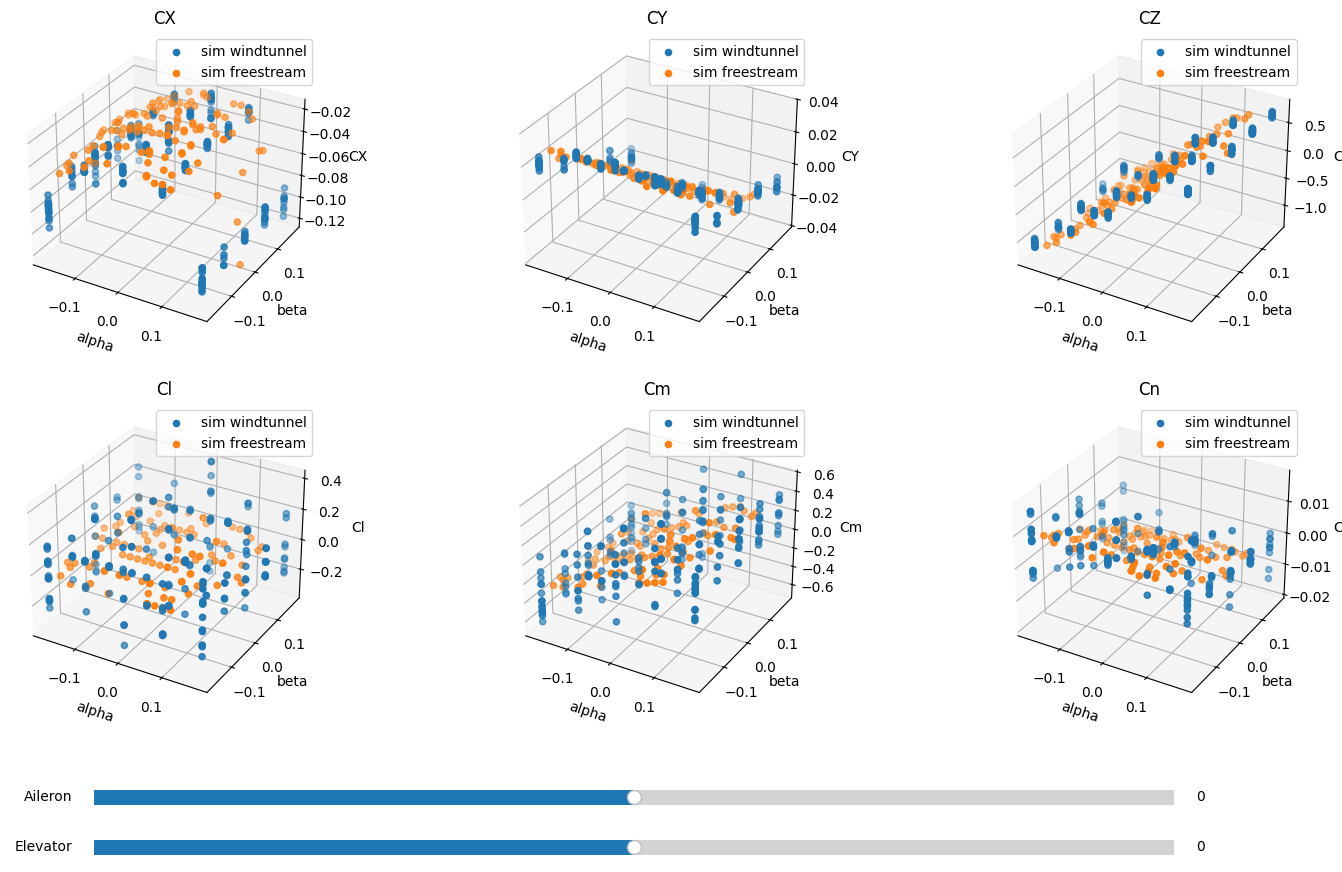

In [16]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def create_interactive_aero_plot(data):
    # Create main figure with subplots
    fig = plt.figure(figsize=(18, 10))
    
    # Add space at bottom for sliders
    plt.subplots_adjust(bottom=0.2)
    
    # Create 6 subplots for different coefficients
    axes = []
    for i in range(6):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        ax.set_title(f"{data.columns[i + 6]}")
        axes.append(ax)
    
    # Create slider axes
    ax_aileron = plt.axes([0.2, 0.1, 0.6, 0.03])
    ax_elevator = plt.axes([0.2, 0.05, 0.6, 0.03])
    
    # Create sliders
    s_aileron = Slider(ax_aileron, 'Aileron', data['aileron'].min(), data['aileron'].max(), valinit=0)
    s_elevator = Slider(ax_elevator, 'Elevator', data['elevator'].min(), data['elevator'].max(), valinit=0)
    
    def update(val):
        # Clear all subplots
        for ax in axes:
            ax.clear()
            
        # Filter data based on slider values
        filtered_data = data[
            (data['aileron'].between(s_aileron.val-0.1, s_aileron.val+0.1)) & 
            (data['elevator'].between(s_elevator.val-0.1, s_elevator.val+0.1))
        ]
        
        # Plot filtered data
        plot(fig, filtered_data)
        fig.canvas.draw_idle()
    
    s_aileron.on_changed(update)
    s_elevator.on_changed(update)
    
    # Initial plot
    plot(fig, data)
    plt.show()

# Use it by calling:
create_interactive_aero_plot(data)


In [6]:
data['aileron'].between(0,100)

0       True
1       True
2       True
3       True
4       True
        ... 
2690    True
2691    True
2692    True
2693    True
2694    True
Name: aileron, Length: 2695, dtype: bool

interactive(children=(FloatSlider(value=5.0, description='tf', max=20.0, min=1.0), FloatSlider(value=0.0, desc…

<function __main__.interactive_plot(tf, aileron, elevator)>

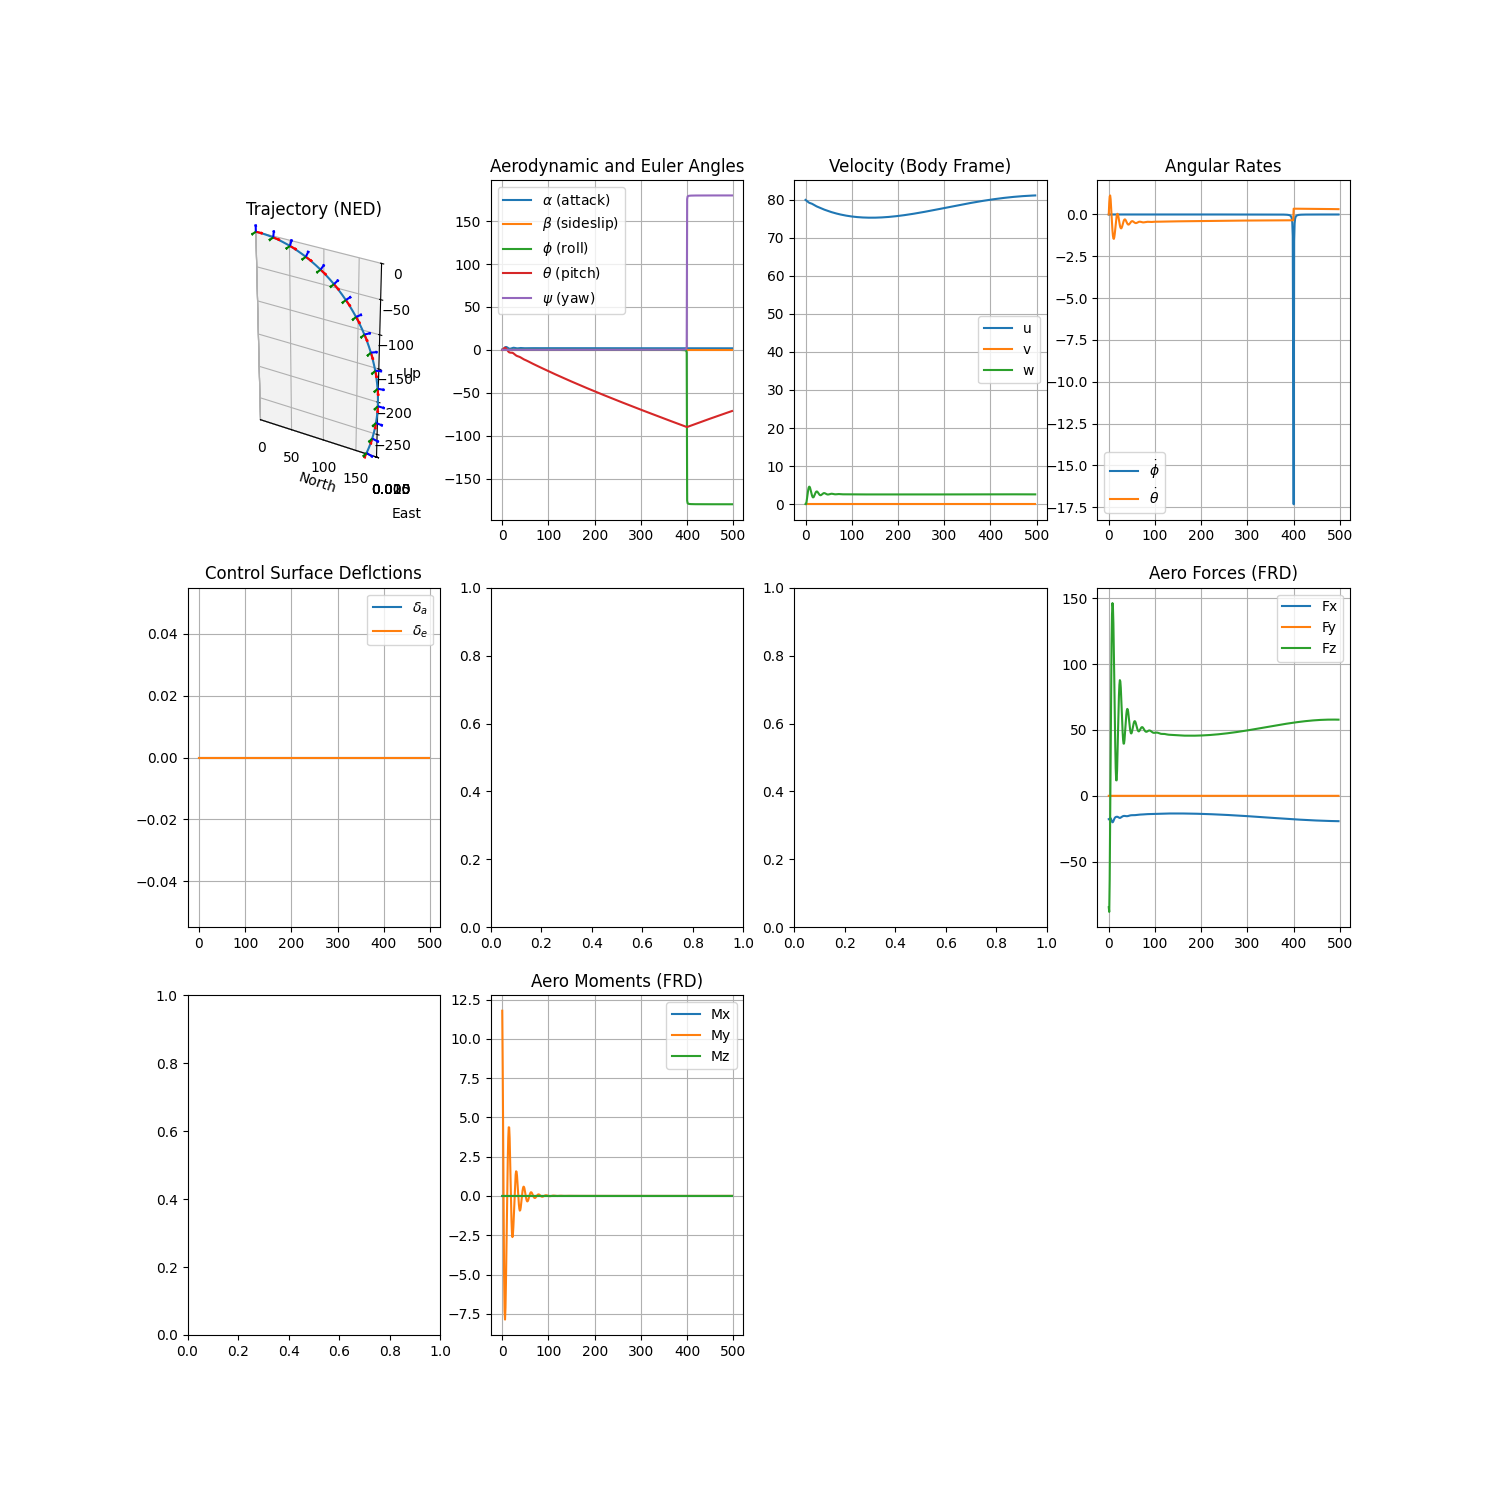

In [ ]:
import json
import os
import numpy as np
import casadi as ca
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

from dynamics_minimal import Aircraft, AircraftOpts, TrajectoryConfiguration
from utils import load_model
from liecasadi import Quaternion
from plotting_minimal import TrajectoryPlotter

%matplotlib ipympl


# Load required modules and configurations
model = load_model()
traj_dict = json.load(open('../data/glider/problem_definition.json'))
trajectory_config = TrajectoryConfiguration(traj_dict)
aircraft_config = trajectory_config.aircraft

poly_path = Path("../main/fitted_models_casadi.pkl")
opts = AircraftOpts(poly_path=poly_path, aircraft_config=aircraft_config)
aircraft = Aircraft(opts=opts)



# Function to run the simulation
def simulate_trajectory(tf, aileron, elevator, plotter):
    dt = 0.01
    num_steps = int(tf / dt)

    # Initial conditions
    x0 = np.zeros(3)
    v0 = ca.vertcat([80, 0, 0])
    q0 = Quaternion(ca.vertcat(0, 0, 0, 1))
    omega0 = np.array([0, 0, 0])

    state = ca.vertcat(q0, x0, v0, omega0)
    control = np.zeros(aircraft.num_controls)
    control[0] = aileron  # Aileron deflection
    control[1] = elevator  # Elevator deflection

    dyn = aircraft.state_update.expand()
    state_list = np.zeros((aircraft.num_states, num_steps))
    control_list = np.zeros((aircraft.num_controls, num_steps))

    for i in tqdm(range(num_steps), desc="Simulating Trajectory"):
        if np.isnan(state[0]):
            print("Aircraft crashed!")
            break
        elif np.linalg.norm(state[0:4]) > 1000:
            print("Aircraft crashed!")
            break
        else:
            state_list[:, i] = state.full().flatten()
            control_list[:, i] = control
            state = dyn(state, control, dt)

    # Save trajectory data
    filepath = os.path.join("../data", "trajectories", "simulation.h5")
    if os.path.exists(filepath):
        os.remove(filepath)

    with h5py.File(filepath, "a") as h5file:
        grp = h5file.create_group(f'iteration_0')
        grp.create_dataset('state', data=state_list[:, :i - 1])
        grp.create_dataset('control', data=control_list[:, :i - 1])

    # Plot the results
    
    plotter.plot(filepath=filepath)
    plt.draw()



# Interactive widgets
tf_widget = widgets.FloatSlider(value=5.0, min=1.0, max=20.0, step=0.1, description='Final Time (s)')
aileron_widget = widgets.FloatSlider(value=2.0, min=-5.0, max=5.0, step=0.1, description='Aileron (deg)')
elevator_widget = widgets.FloatSlider(value=2.0, min=-5.0, max=5.0, step=0.1, description='Elevator (deg)')
simulate_button = widgets.Button(description="Run Simulation")

# # Callback to run simulation
# def on_simulate_click(change):
#     simulate_trajectory(tf_widget.value, aileron_widget.value, elevator_widget.value, plotter=plotter)

# simulate_button.on_click(on_simulate_click)

# # Display the widgets
# display(tf_widget, aileron_widget, elevator_widget, simulate_button)
plotter = TrajectoryPlotter(aircraft, figsize=(None, None))
def interactive_plot(tf, aileron, elevator):
    
    simulate_trajectory(tf, aileron, elevator, plotter)

interact(
    interactive_plot, 
    tf=widgets.FloatSlider(min=1.0, max=20.0, step=0.1, value=5.0),
    aileron=widgets.FloatSlider(min=-5, max=5.0, step=0.1, value=0.0),
    elevator=widgets.FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0)
)


In [2]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
